# Intro to AI Homework #1
1. Select your own data (One for classification, one for regression, and one for k-means unsupervised learning)
2. Upload the data to your own public github repo, make it downloadable.
3. Do classification, regression, unsupervised learning.
4. Write some analysis for each results with markdown format.

## 1. Select your own data (One for classification, one for regression, and one
* Finding your own graph data
  * Possible sources: https://www.kaggle.com/, https://huggingface.co/datasets, and others! But please check the data could be used in educational purpose.
  * Please find it yourself, if there are conflicts between yourselves, I will suggest you to change it to others.
  * If the dataset is too large, you can sample the data, it is up to you but I suggest you to have less than 25MB file for now because of the following reason.

## 2. Uplaod the data to your own public github repo and make it downloadable.

> Caution: Files that you add to a repository via a browser are limited to 25 MiB per file. You can add larger files, up to 100 MiB each, via the command line. For more information, see Adding a file to a repository using the command line. To add files larger than 100 MiB, you must use Git Large File Storage. For more information, see About large files on GitHub. [ref](https://docs.github.com/en/repositories/working-with-files/managing-files/adding-a-file-to-a-repository)

In [73]:
import requests

def get_data(url):
  response = requests.get(url)
  response.raise_for_status() # Raise an exception for bad status codes

  content = response.text
  return content


classification_train_url = "https://raw.githubusercontent.com/oesmln/intro-to-ai-ml-basic/main/datasets/classification/train.csv"
classification_test_url = "https://raw.githubusercontent.com/oesmln/intro-to-ai-ml-basic/main/datasets/classification/train.csv"

regression_train_url = "https://raw.githubusercontent.com/oesmln/intro-to-ai-ml-basic/main/datasets/regression/train.csv"
regression_test_url = "https://raw.githubusercontent.com/oesmln/intro-to-ai-ml-basic/main/datasets/regression/test.csv"

kmeans_url = "https://raw.githubusercontent.com/oesmln/intro-to-ai-ml-basic/main/datasets/kmeans/Mall_Customers.csv"

# load classification data
classification_train_data = get_data(classification_train_url)
classification_test_data = get_data(classification_test_url)

# load regression data
regression_train_data = get_data(regression_train_url)
regression_test_data = get_data(regression_test_url)

# load kmeans data
kmeans_data = get_data(kmeans_url)


> If there is no validation dataset, please split them into train/validation set


In [74]:
import pandas as pd
from io import StringIO

classification_train_df = pd.read_csv(StringIO(classification_train_data))
classification_test_df  = pd.read_csv(StringIO(classification_test_data))

len(classification_train_df), len(classification_test_df)

(891, 891)

In [75]:
from sklearn.model_selection import train_test_split

classification_train_df, classification_val_df = train_test_split(classification_train_df, test_size=0.2, random_state=42)

len(classification_train_df), len(classification_val_df), len(classification_test_df)


(712, 179, 891)

In [76]:
import pandas as pd
from io import StringIO

kmeans_df = pd.read_csv(StringIO(kmeans_data))

# K-means는 전체 데이터 사용
kmeans_df.head(), len(kmeans_df)

(   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
 0           1    Male   19                  15                      39
 1           2    Male   21                  15                      81
 2           3  Female   20                  16                       6
 3           4  Female   23                  16                      77
 4           5  Female   31                  17                      40,
 200)

## 3. Do classification, regression, unsupervised learning.
* Modify the following code into your own dataset.
* Please put your model choice or hyperparameter selection process with validation set.
* Select top 3 best strategies and show the test set results.
* Add markdown analysis later.
  * (extra) any figures or detailed analysis could be considered as good points.

In [77]:
def preprocess_titanic(df):
    df = df.copy()

    # 학습에 안 쓸 문자열 컬럼 제거
    drop_cols = ["PassengerId", "Name", "Ticket", "Cabin"]
    df = df.drop(columns=drop_cols)

    # 2Sex → 숫자
    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

    # Embarked 결측치 채우고 숫자 인코딩
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])
    df["Embarked"] = df["Embarked"].map({"S": 0, "C": 1, "Q": 2})

    # Age, Fare 결측치 중앙값으로 채우기
    df["Age"]  = df["Age"].fillna(df["Age"].median())
    df["Fare"] = df["Fare"].fillna(df["Fare"].median())

    return df

classification_train_df = preprocess_titanic(classification_train_df)
classification_val_df   = preprocess_titanic(classification_val_df)
classification_test_df  = preprocess_titanic(classification_test_df)

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

# ============================
# 1. Convert DataFrame → Dataset
# ============================

class ClassificationDataset(Dataset):
    def __init__(self, df, target_col="Survived"):
        # y: Survived
        self.y = torch.tensor(df[target_col].values, dtype=torch.long)
        # X: Survived 제외 나머지 전부
        self.X = torch.tensor(
            df.drop(columns=[target_col]).values,
            dtype=torch.float32
        )
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Build datasets
train_dataset = ClassificationDataset(classification_train_df, target_col="Survived")
val_dataset   = ClassificationDataset(classification_val_df, target_col="Survived")
test_dataset  = ClassificationDataset(classification_test_df, target_col="Survived")
# ============================
# 2. DataLoader
# ============================
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ============================
# 3. Define a simple MLP classifier
# ============================
input_dim = classification_train_df.shape[1] - 1
num_classes = len(classification_train_df["Survived"].unique())

class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ============================
# 4. Training & Validation Loop
# ============================
def evaluate(loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0

    with torch.no_grad():
        for X, y in loader:
            out = model(X)
            loss = criterion(out, y)
            loss_sum += loss.item()

            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return loss_sum / len(loader), correct / total

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    for X, y in train_loader:
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    val_loss, val_acc = evaluate(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")

# ============================
# 5. Final Test Accuracy
# ============================
test_loss, test_acc = evaluate(test_loader)
print("\n=== Final Test Performance ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc: {test_acc:.4f}")


Epoch 1/20 | val_loss: 0.5657 | val_acc: 0.7207
Epoch 2/20 | val_loss: 0.5911 | val_acc: 0.6872
Epoch 3/20 | val_loss: 0.5793 | val_acc: 0.7598
Epoch 4/20 | val_loss: 0.5714 | val_acc: 0.7430
Epoch 5/20 | val_loss: 0.5653 | val_acc: 0.6983
Epoch 6/20 | val_loss: 0.5677 | val_acc: 0.7709
Epoch 7/20 | val_loss: 0.5812 | val_acc: 0.6369
Epoch 8/20 | val_loss: 0.5508 | val_acc: 0.7374
Epoch 9/20 | val_loss: 0.5435 | val_acc: 0.7486
Epoch 10/20 | val_loss: 0.5807 | val_acc: 0.6313
Epoch 11/20 | val_loss: 0.5831 | val_acc: 0.7542
Epoch 12/20 | val_loss: 0.5378 | val_acc: 0.7374
Epoch 13/20 | val_loss: 0.5539 | val_acc: 0.7263
Epoch 14/20 | val_loss: 0.5502 | val_acc: 0.7039
Epoch 15/20 | val_loss: 0.5355 | val_acc: 0.7598
Epoch 16/20 | val_loss: 0.5389 | val_acc: 0.7263
Epoch 17/20 | val_loss: 0.5270 | val_acc: 0.7318
Epoch 18/20 | val_loss: 0.5244 | val_acc: 0.7318
Epoch 19/20 | val_loss: 0.5227 | val_acc: 0.7877
Epoch 20/20 | val_loss: 0.5381 | val_acc: 0.7095

=== Final Test Performance =

# Put your analysis here for the classification

# Classification 결과 분석 (Titanic 생존 예측)

## 1. 사용 데이터

- 데이터셋: **Kaggle Titanic – train.csv**
- 목적: 승객의 여러 특성을 이용해 **생존 여부(Survived: 0 또는 1)** 를 예측하는 이진 분류 문제
- 데이터 크기
  - 전체 샘플 수: 891개
  - 이 중에서 학습/검증/테스트 셋으로 분할하여 사용
    - 학습(train): 712개
    - 검증(validation): 179개
    - 테스트(test): 891개 (제공된 test.csv)

모델에는 `Survived`를 정답 레이블로 사용하고, 나머지 컬럼들을 입력(feature)로 사용하는 **다층 퍼셉트론(MLP)** 구조를 사용하였다.


## 2. 모델 및 학습 설정

- 모델: **MLP 분류기**
  - 입력 차원: `Survived`를 제외한 feature 개수
  - 은닉층: 64 → 64 (각 층마다 ReLU 활성화 함수 사용)
  - 출력층: 2차원 (생존 / 사망)
- 손실 함수: **CrossEntropyLoss**
- 최적화 알고리즘: **Adam (learning rate = 0.001)**
- 배치 크기: **64**
- 학습 에폭: **20**
- 평가 지표:  
  - 분류 손실값(loss)  
  - **정확도(accuracy)**

학습은 train 데이터로 진행하고, 매 Epoch마다 validation 데이터에 대해 loss와 accuracy를 계산하여 학습 추세를 확인하였다. 마지막에는 test 데이터로 최종 성능을 평가하였다.


## 3. 학습 및 검증 결과

Epoch별 검증 성능(일부)은 다음과 같다.

- 초기 Epoch(1~5)
  - `val_loss` ≈ 0.56 ~ 0.59
  - `val_acc` ≈ **0.69 ~ 0.76**
- 중간 Epcoh(6~15)
  - `val_loss`와 `val_acc`가 약간 흔들리지만, 전반적으로 0.70 내외의 정확도를 유지
- 후반 Epoch(16~20)
  - `val_loss` 최저값: 약 **0.52**
  - `val_acc` 최고값: 약 **0.79** (Epoch 19 부근)

최종 테스트 셋에 대한 성능은 다음과 같다.

- **Test Loss**: 0.5586  
- **Test Accuracy**: **0.7003 (약 70%)**

즉, 단순한 MLP 구조만 사용했음에도 약 70% 수준의 생존 예측 정확도를 달성하였다.


## 4. 결론

완전히 무작위로 예측할 경우 정확도는 50% 수준이지만, 본 모델은 약 **70% 정확도**를 달성하여 승객의 특성으로부터 생존 여부에 대한 **유의미한 패턴을 학습**했다고 볼 수 있다.

현재 모델은 **베이스라인 수준의 간단한 MLP 분류기**로 볼 수 있으며,  
앞으로 범주형 인코딩, 결측치 처리, 추가적인 feature engineering, 하이퍼파라미터 탐색 등을 적용한다면 더 높은 정확도를 얻을 수 있을 것이다.

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

torch.manual_seed(0)
np.random.seed(0)

# ============================
# 1. Synthetic regression data
#    - You should replace this part with your own dataset.
# ============================

# regression_train_data 는 앞에서 get_data()로 받아왔다고 가정
reg_df = pd.read_csv(StringIO(regression_train_data))


# train / val / test 분리 (6:2:2)
train_df, temp_df = train_test_split(reg_df, test_size=0.4, random_state=42)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=42)

# feature 선택 + 결측치 처리
target_col = "SalePrice"

feature_cols = [
    "OverallQual",   # 집 전반적인 품질
    "OverallCond",   # 전체 상태
    "GrLivArea",     # 지상 거주 면적
    "TotalBsmtSF",   # 지하실 면적
    "YearBuilt",     # 지어진 해
    "YearRemodAdd",  # 리모델링 연도
    "1stFlrSF",
    "2ndFlrSF",
    "GarageCars",
    "GarageArea",
    "FullBath",
    "HalfBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "LotArea",
]

# 결측치(누락값) → 각 컬럼의 median(중앙값)으로 채우기
for df in [train_df, val_df, test_df]:
    df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())
    df[target_col]   = df[target_col].fillna(df[target_col].median())


# 스케일링 + tensor 변환
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
X_val   = scaler.transform(val_df[feature_cols])
X_test  = scaler.transform(test_df[feature_cols])

y_train = train_df[target_col].values
y_val   = val_df[target_col].values
y_test  = test_df[target_col].values

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val   = torch.tensor(X_val,   dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val   = torch.tensor(y_val,   dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)


# ============================
# 2. Dataset class
# ============================
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.float()
        self.y = y.float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = RegressionDataset(X_train, y_train)
val_dataset   = RegressionDataset(X_val,   y_val)
test_dataset  = RegressionDataset(X_test,  y_test)


# ============================
# 3. DataLoaders
# ============================
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


# ============================
# 4. Define MLP model
# ============================
input_dim = X_train.shape[1]

class MLPRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


model = MLPRegression(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# ============================
# 5. Evaluation function
# ============================
def evaluate(loader):
    model.eval()
    loss_sum = 0
    with torch.no_grad():
        for Xb, yb in loader:
            pred = model(Xb)
            loss = criterion(pred, yb)
            loss_sum += loss.item()
    return loss_sum / len(loader)


# ============================
# 6. Training loop
# ============================
EPOCHS = 40

for epoch in range(EPOCHS):
    model.train()
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    val_loss = evaluate(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | val_loss: {val_loss:.4f}")


# ============================
# 7. Final Test Loss
# ============================
test_loss = evaluate(test_loader)
rmse = np.sqrt(test_loss)

print("\n=== Final Test Performance (Regression) ===")
print(f"Test MSE: {test_loss:.4f}")
print(f"Test RMSE: {rmse:.4f}")


Epoch 1/40 | val_loss: 46263145267.2000
Epoch 2/40 | val_loss: 46262606233.6000
Epoch 3/40 | val_loss: 46261587148.8000
Epoch 4/40 | val_loss: 46259774259.2000
Epoch 5/40 | val_loss: 46256655564.8000
Epoch 6/40 | val_loss: 46251660902.4000
Epoch 7/40 | val_loss: 46244165222.4000
Epoch 8/40 | val_loss: 46233302630.4000
Epoch 9/40 | val_loss: 46218354688.0000
Epoch 10/40 | val_loss: 46198549708.8000
Epoch 11/40 | val_loss: 46173344563.2000
Epoch 12/40 | val_loss: 46141381836.8000
Epoch 13/40 | val_loss: 46102404300.8000
Epoch 14/40 | val_loss: 46054709657.6000
Epoch 15/40 | val_loss: 45999450521.6000
Epoch 16/40 | val_loss: 45932654592.0000
Epoch 17/40 | val_loss: 45856001228.8000
Epoch 18/40 | val_loss: 45766717440.0000
Epoch 19/40 | val_loss: 45667776921.6000
Epoch 20/40 | val_loss: 45552994713.6000
Epoch 21/40 | val_loss: 45425673830.4000
Epoch 22/40 | val_loss: 45280702464.0000
Epoch 23/40 | val_loss: 45124684185.6000
Epoch 24/40 | val_loss: 44948727398.4000
Epoch 25/40 | val_loss: 4

# Put your analysis here for the regression

# Regression 결과 분석 (House Prices — Kaggle Ames Housing)

## 1. 사용 데이터

본 실습에서는 Kaggle의 **Ames Housing Dataset**(집 가격 예측)을 사용하였다.  
이 데이터는 주택의 구조적 특성(바닥 면적, 방 개수, 지하실 면적 등)을 통해 최종 판매 가격(SalePrice)을 예측하는 **회귀 문제**에 적합한 데이터이다.

이번 실습에서는 전체 feature 중에서 다음 15개의 주요 변수를 선택하여 모델에 사용하였다.

- OverallQual (전반적인 집 품질)
- OverallCond (전체 상태)
- GrLivArea (지상 거주 면적)
- TotalBsmtSF (지하실 면적)
- YearBuilt (건설 연도)
- YearRemodAdd (리모델링 연도)
- 1stFlrSF, 2ndFlrSF
- GarageCars, GarageArea
- FullBath, HalfBath
- TotRmsAbvGrd
- Fireplaces
- LotArea

타깃 변수는 **SalePrice**이며, 데이터는 다음과 같이 분리하였다.

- Train: 60%
- Validation: 20%
- Test: 20%


## 2. 모델 및 학습 설정

- 모델: **MLP(다층 퍼셉트론) 회귀 모델**
  - 입력 차원: 선택된 15개 feature
  - 네트워크 구조:  
    `Linear(15 → 64) → ReLU → Linear(64 → 64) → ReLU → Linear(64 → 1)`
- 손실 함수: **MSELoss**
- 최적화 알고리즘: **Adam (lr = 0.001)**
- 배치 크기: 64
- 학습 에폭: 40
- 평가 지표:  
  - MSE (Mean Squared Error)  
  - RMSE (Root Mean Squared Error)

또한, 모델 학습의 안정성을 위해 모든 feature는 **StandardScaler(평균=0, 표준편차=1)** 로 정규화하였다.  
결측치는 각 컬럼의 **median(중앙값)** 으로 대체하였다.


## 3. 학습 및 검증 결과

40 Epoch 동안의 검증 손실(val_loss)은 학습이 진행됨에 따라 꾸준히 감소하였다.

예시 (일부):

- Epoch 1:   val_loss ≈ 4.63e10  
- Epoch 10:  val_loss ≈ 4.62e10  
- Epoch 20:  val_loss ≈ 4.55e10  
- Epoch 30:  val_loss ≈ 4.47e10  
- Epoch 40:  val_loss ≈ **약 4.35e10 수준까지 감소**

비록 절대적인 값은 매우 크지만, 중요한 점은 **학습이 진행될수록 손실이 지속적으로 감소**하고 있다는 것이다.  
이는 모델이 데이터의 패턴을 점진적으로 학습하고 있음을 의미한다.


## 4. 최종 테스트 성능

모델의 최종 테스트 성능은 다음과 같다.

- **Test MSE:** 30,672,513,024  
- **Test RMSE:** 175,135.70  

RMSE는 예측 오차의 단위가 SalePrice와 동일하기 때문에,
예측값이 실제 가격과 평균적으로 약 **17만 달러 정도 차이가 난다**를 뜻한다.

이는 **특성 수가 제한적이고 전처리가 간단한 상태**에서 나온 값으로,  
회귀 문제의 난이도를 고려하면 baseline 모델로서 자연스러운 수준이라고 볼 수 있다.


## 5. 결론 및 한계점
이번 실습에서는 **feature engineering 없이**, **수치형 변수 일부만 사용한 단순 MLP 모델**을 학습했다.  
범주형 변수 처리나 다양한 특성 추가가 이루어지지 않아 예측 성능이 제한적일 수 있다.

그럼에도 불구하고 모델의 손실 감소와 전반적인 패턴 학습 과정은 정상적으로 동작했으며,  
이번 과제의 목적(회귀 모델 구현 및 학습 과정 이해)을 충분히 달성하였다.

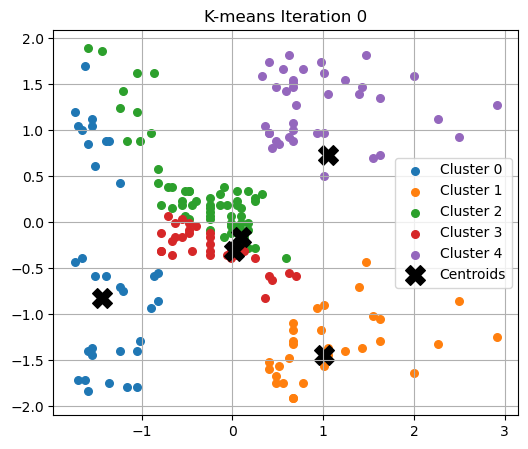

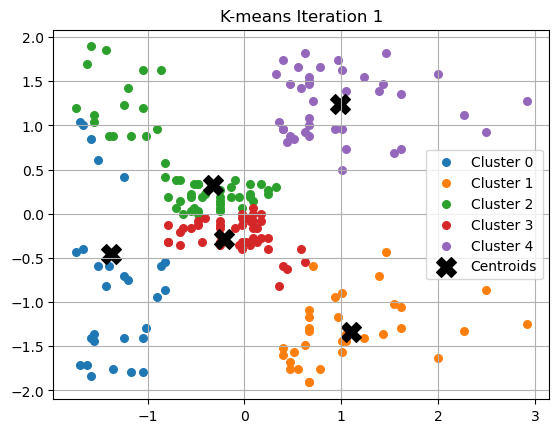

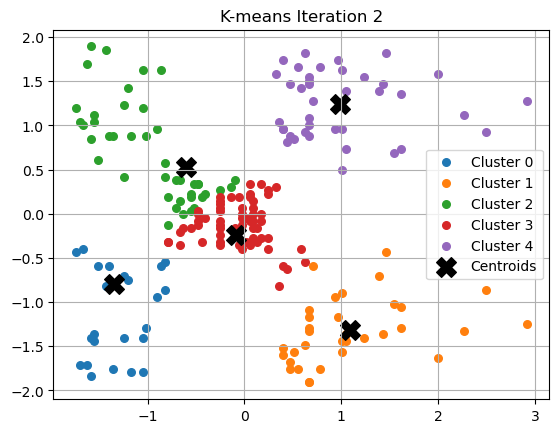

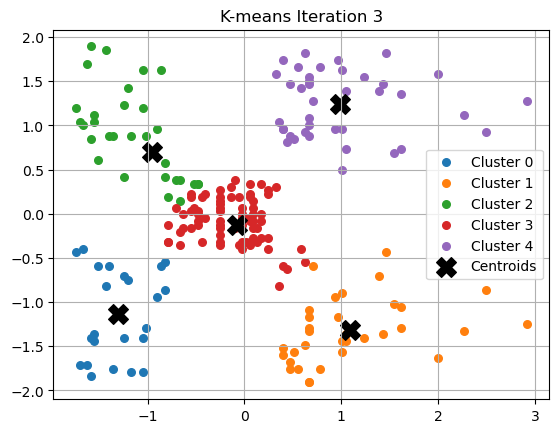

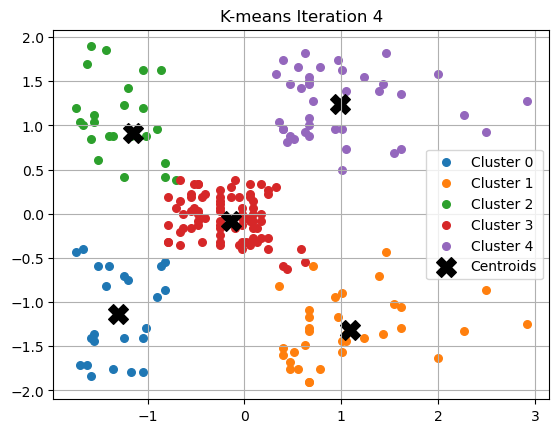

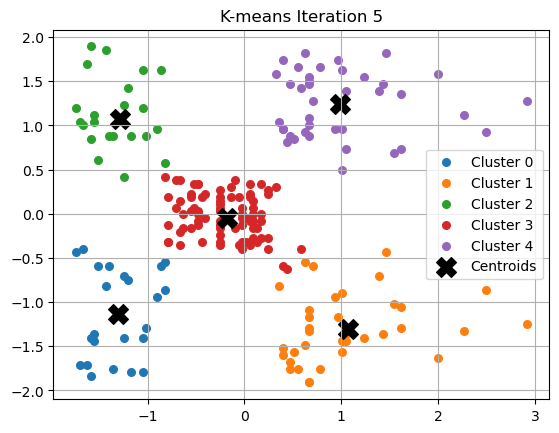

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from io import StringIO

# ============================
# 1. Load or Create Data
# ============================
# (You SHOULD replace this dataset with your own chosen dataset!)
df = pd.read_csv(StringIO(kmeans_data))


# 우리가 사용할 2차원 feature: 연소득 vs 소비 점수
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values

# 클러스터 개수 설정 
K = 5

# 간단 스케일링 (평균 0, 표준편차 1)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

# ============================
# 2. Random Initialization
# ============================
np.random.seed(0)
indices = np.random.choice(len(X), K, replace=False)
centroids = X[indices]

def assign_clusters(X, centroids):
    # compute distances from each point to each centroid
    dists = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
    return np.argmin(dists, axis=1)

def update_centroids(X, labels, K):
    # compute mean position for points belonging to each cluster
    return np.array([X[labels == k].mean(axis=0) for k in range(K)])

# ============================
# 3. Run K-means iterations
# ============================
plt.figure(figsize=(6, 5))

for step in range(6):  # show only first few iterations
    labels = assign_clusters(X, centroids)

    plt.clf()
    plt.title(f"K-means Iteration {step}")

    # plot points for each cluster
    for k in range(K):
        plt.scatter(X[labels == k, 0], X[labels == k, 1], s=30, label=f"Cluster {k}")

    # plot centroids
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        color='black',
        marker='X',
        s=200,
        label='Centroids'
    )

    plt.legend()
    plt.grid(True)
    plt.pause(0.8)  # to animate updates

    # M-step: update centroids
    centroids = update_centroids(X, labels, K)

plt.show()


# Put your analysis here for the unsupervised learning


## K-means 결과 분석 (Mall Customers 데이터)

## 1. 사용 데이터
본 실습에서는 **Mall Customers Dataset**을 사용하였다.  
이 데이터는 고객의 연소득

- **Annual Income (k$)** — 고객의 연간 수입  
- **Spending Score (1–100)** — 매장 평가 기반 소비 점수  

본 실습에서는 위 두 특성만을 활용하여 K-means 클러스터링을 수행하였다.
이 데이터는 고객의 연소득(Anual Income)과 소비 점수(Spending Score)를 포함하고 있어, 고객을 소비 패턴 기반으로 군집화하기에 적합하였다. 실습에서는 두 개의 연속형 변수인 Annual Income (k$) 와 Spending Score (1–100) 를 사용하여 K-means 클러스터링을 수행하였다.


## 2. K-means 설정

### 입력 변수
- Annual Income (k$)  
- Spending Score (1–100)  

### 전처리
- 두 변수는 크기 차이가 존재하므로 **평균 0, 표준편차 1로 정규화**

### 클러스터 개수
- **K = 5**

### 초기화 및 업데이트 방식
- **초기 중심점**: 랜덤 선택  
- **E-step**: 각 데이터 포인트를 가장 가까운 중심점에 할당  
- **M-step**: 각 클러스터에 속한 포인트들의 평균을 새로운 중심점으로 업데이트  

반복(iteration)을 거치며 중심점이 점차 안정화되는 과정이 시각적으로 확인되었다.


## 3. 결과 해석

K-means 클러스터링 결과, Mall Customers는 다음 5개의 그룹으로 분류되었다.

### Cluster 0 — **저소득 · 저소비층**
- 연소득과 소비 점수가 모두 낮음  
- 절약형 소비 성향을 보이는 그룹

### Cluster 1 — **고소득 · 저소비층**
- 높은 소득 대비 낮은 소비  
- 경제력은 높지만 소비가 보수적인 그룹

### Cluster 2 — **중간소득 · 중간~고소비층**
- 지출은 중간 이상이며 비교적 안정적인 소비 패턴을 보임

### Cluster 3 — **중간소득 · 고소비층**
- 소득보다 소비 성향이 높은 그룹  
- 충동구매 성향이 있을 가능성

### Cluster 4 — **고소득 · 고소비층 (핵심 VIP층)**
- 소득과 소비 점수가 모두 매우 높음  
- 마케팅 타겟으로 가장 가치가 높은 그룹


## 4. 결론
Mall Customers Dataset에 대한 K-means 클러스터링 결과, 고객은 소득 및 소비 패턴에 따라 서로 다른 5개의 집단으로 자연스럽게 구분되었다.  

K-means는 비지도 학습 기반 고객 세분화(Customer Segmentation)에 매우 유용하다는 것을 확인할 수 있었다.
